In [2]:
import os
import sys
from pathlib import Path
sys.path.insert(1, str(Path(os.getcwd()).parent / "src"))

In [3]:
import data_loader
from concentr_diffs_pathlength import *
from plotting import *
from mbll_functions import *
from utils import *
from mcs_function import *
from pathlib import Path
import config
import pickle
from scipy.optimize import least_squares
import pmcx
from tqdm.notebook import tqdm
import imageio

import matplotlib.pyplot as plt

In [4]:
config.gpuid

6

In [5]:
config.m_params_path

PosixPath('/home/leon_ivan/nonlinear-fit/dataset/m_parameters.pickle')

In the Jacques model, diffuse reflectance is given as $$R_d = \exp(-A\delta \mu_a)$$, where A depends on the ratio of the absorption and scattering $N = \frac{\mu_s'}{\mu_a}$ coefficient, and is modelled as
$$ A(N) = m_1 + m_2\exp(\frac{\ln(N)}{m_3}) $$
and $\delta$ is $$\delta = (3\mu_a(\mu_s' + \mu_a))^{-\frac{1}{2}}$$
A also depends on the refractive index. The $m_i$-parameters in paper and Jacque's website are based on a refractive index of 1.33. For the brain we expect 1.36 (gray matter) to 1.4 (blood vessels). To determine the $m_i$ for these indices, we run Monte Carlo Simulations with reasonable absorption/scattering coefficients and fit the $m_i$ to the obtained values for A.\
For absorption/scattering coefficients we use literature values of gray matter and blood vessel tissue. Additionally, we use some very high values for $N$, as it was done on Jacque's website.

In [6]:
 # both inclusive
loader = data_loader.DataLoader(None, 450, 999)
# absorption spectra for HbO2, Hbb, oxCCO, redCCO, water and fat
mu_a_matrix = loader.absorption_coefs(
    use_diff_oxycco = False,
    use_water_and_fat = True
)

In [7]:
sample_wavelengths = np.arange(loader.wavelength_left_cut, loader.wavelength_right_cut, 25)
if sample_wavelengths[-1] != loader.wavelength_right_cut:
    sample_wavelengths = np.append(sample_wavelengths, loader.wavelength_right_cut)[1:]
print(sample_wavelengths)

[475 500 525 550 575 600 625 650 675 700 725 750 775 800 825 850 875 900
 925 950 975 999]


In [8]:
g_gm = 0.85
refractive_idx_gm = 1.36
mu_a_gm = data_loader.DataLoader.mu_a_func_gray_matter(sample_wavelengths) / 10
mu_s_gm = data_loader.DataLoader.mu_s_red_func_gray_matter(sample_wavelengths) / 10 / (1 - g_gm)

In [9]:
g_bv = 0.935
refractive_idx_bv = 1.4
mu_a_bv = data_loader.DataLoader.mu_a_func_blood_vessel(sample_wavelengths) / 10
mu_s_bv = data_loader.DataLoader.mu_s_func_blood_vessel(sample_wavelengths) / 10

In [10]:
# For refractive index of 1.38 compute the m-parameters based on combined blood and cortex values
g_combined = 0.9
refractive_idx_combined = 1.38
mu_a_combined = np.concatenate((mu_a_gm, mu_a_bv))
mu_s_combined = np.concatenate((mu_s_gm * (1-g_gm) / (1-g_combined), mu_s_bv * (1-g_bv) / (1-g_combined)))

In [11]:
# Optionally append very high N values, as it was done on Jacques website
#mu_a_gm = np.append(mu_a_gm, np.repeat((1 - g_gm), 3))
#mu_s_gm = np.append(mu_s_gm, np.array([1e2, 1e3, 5e3]))
#mu_a_bv = np.append(mu_a_bv, np.repeat((1 - g_bv), 3))
#mu_s_bv = np.append(mu_s_bv, np.array([1e2, 1e3, 5e3]))
mu_a_combined = np.append(mu_a_combined, np.repeat((1 - g_combined), 3))
mu_s_combined = np.append(mu_s_combined, np.array([1e2, 1e3, 5e3]))

In [12]:
mcs_params_total = {
    refractive_idx_gm: (mu_a_gm, mu_s_gm, g_gm),
    refractive_idx_bv: (mu_a_bv, mu_s_bv, g_bv),
    refractive_idx_combined: (mu_a_combined, mu_s_combined, g_combined)
}

In [13]:
mu_a_combined.shape

(47,)

In [14]:
A_vals = dict()
dref_vals = dict()
m_params = dict()
N_vals = dict()

# empty log file
open(config.m_params_path.parent / "log.txt", "w").close()

# make sure to make this a separate array, don't create directly in cfg!
prop_mcs = np.array([[0,0,1,1],[0,0,1.2,1.5]])

vol = np.ones((100, 100, 120), dtype="uint8")

cfg = {
    "nphoton": 1e7,
    "maxdetphoton": 1e7,
    "vol": vol,
    "tstart":0,
    "tend":5e-9,
    "tstep":5e-9,
    "autopilot": 1,
    "gpuid": config.gpuid,
    "prop": prop_mcs,
    "bc": "ccrcca",#001000",
    "isspecular": 1,
    "srcdir": [0,0,1],
    "srctype": "planar",
    "srcpos": [0, 0, 0],
    "srcparam1": [100, 0, 0, 0], # 3D position of vertex, fourth coordinate is irrelevant
    "srcparam2": [0, 100, 0, 0],
    "issrcfrom0": 1,
    #"savedetflag": "dpx",
    "flog": str(config.m_params_path.parent) + "/log.txt",
    "isnormalized": 0,
    "issaveref": 1
}

# necessary to accumulate weights
cfg["vol"][:, :, 0] = 0

def A_residual(m_params, A_vals, N_vals):
    m1, m2, m3 = m_params
    return A_vals - (m1 + m2 * np.exp(np.log(N_vals)/m3))

for refractive_idx, (mu_a_tissue, mu_s_tissue, g_tissue) in mcs_params_total.items():
    A_vals[refractive_idx] = []
    N_vals[refractive_idx] = []
    dref_vals[refractive_idx] = []
    for mu_a, mu_s in zip(mu_a_tissue, mu_s_tissue):
        cfg["prop"][1, 0] = mu_a
        cfg["prop"][1, 1] = mu_s
        cfg["prop"][1, 2] = g_tissue
        cfg["prop"][1, 3] = refractive_idx
        res = pmcx.mcxlab(cfg)
        #mean_pl = pmcx.utils.meanpath(res["detp"])[0]
        mu_s_red = mu_s * (1 - g_tissue)
        delta = 1 / np.sqrt(3 * mu_a * (mu_a + mu_s_red))
        #A = mean_pl / delta
        dref = np.sum(res["dref"][:, :, 0, :]) / cfg["nphoton"]
        dref_vals[refractive_idx].append(dref)
        A = -np.log(dref) / (delta * mu_a)
        A_vals[refractive_idx].append(A)
        print(f"N: {mu_s_red / mu_a}    A:{A}")
        
    N_vals[refractive_idx] = mu_s_tissue * (1 - g_tissue) / mu_a_tissue
    # initial values by Jacques as initialization
    m = np.array([6.3744, 0.3568, 3.4739])
    ls_res = least_squares(A_residual, m, args=(A_vals[refractive_idx], N_vals[refractive_idx]))
    m_params[refractive_idx] = ls_res.x


nphoton: 1e+07
tstart: 0
tstep: 5e-09
tend: 5e-09
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
N: 8.927875223024518    A:7.5878491163060655
nphoton: 1e+07
tstart: 0
tstep: 5e-09
tend: 5e-09
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
N: 10.28116759252159    A:7.613323537644078
nphoton: 1e+07
tstart: 0
tstep: 5e-09
tend: 5e-09
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
N: 6.082674915385583    A:7.539635475916987
nphoton: 1e+07
tstart: 0
tstep: 5e-09
tend: 5e-09
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
N: 3.426661634000641    A:7.555425130391109
nphoton: 1e+07
tstart: 0
tstep: 5e-09
tend: 5e-09
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 1
autopilot: 1
issaveref: 1
isspecular: 1
N: 2.595959186715588    A:7.610008996843303
nphoton: 1e+07
tstart: 0
tstep: 5e-09
tend: 5e-09
maxdetphoton: 1e+07
isnormali

In [13]:
mu_a_gm.shape

(22,)

Compare diffuse reflectance computed during MCS with dref computed here...

Store the parameters...

In [15]:
with open(config.m_params_path, "wb") as f:
    pickle.dump((m_params, A_vals, N_vals, dref_vals), f)

Load the parameters...

In [16]:
with open(config.m_params_path, "rb") as f:
    m_params, A_vals, N_vals, dref_vals = pickle.load(f)

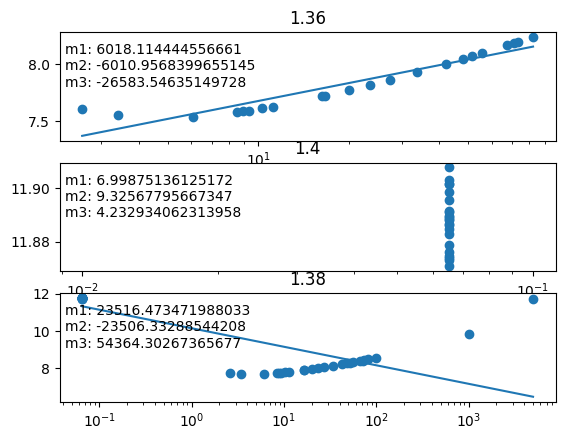

In [18]:
refractive_idxs = [1.36, 1.38, 1.4]

fig, axs = plt.subplots(len(refractive_idxs), 1)

for i, (refractive_idx, (mu_a_tissue, mu_s_tissue, g_tissue)) in enumerate(mcs_params_total.items()):
    m1, m2, m3 = m_params[refractive_idx]
    N_vals = mu_s_tissue * (1 - g_tissue) / mu_a_tissue
    N_vals_interp = np.linspace(np.min(N_vals), np.max(N_vals), 100)
    axs[i].plot(N_vals_interp, m1 + m2*np.exp(np.log(N_vals_interp)/m3))
    axs[i].scatter(N_vals, A_vals[refractive_idx])
    axs[i].set_xscale("log")
    axs[i].set_title(f"{refractive_idx}")
    axs[i].text(0.01, 0.5, f"m1: {m1}\nm2: {m2}\nm3: {m3}", transform=axs[i].transAxes)

plt.show()